In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.inventory import Inventory
from src.Constants import Constants
import numpy as np
from pathlib import Path

# 2011 bazni inventar

In [4]:
root_dir = Path('..')

/home/dionizije/Documents/vk_secap/src/inventory.py:282: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10, 6))


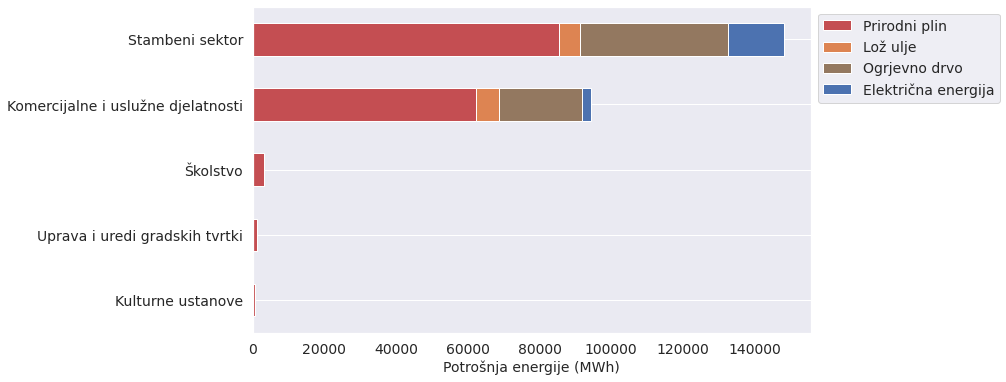

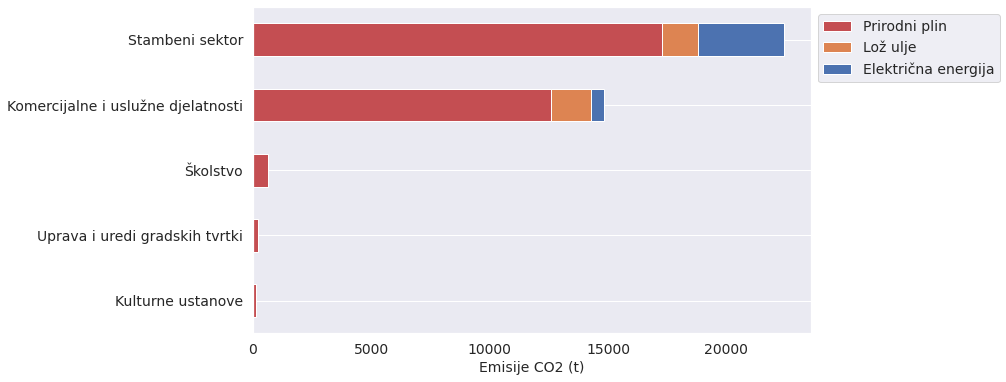

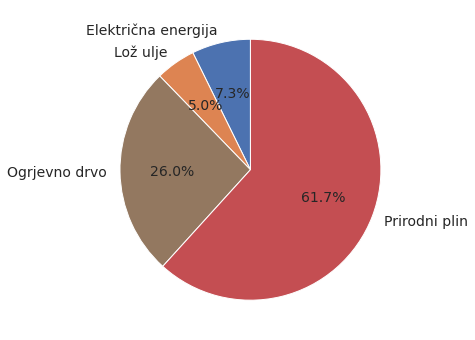

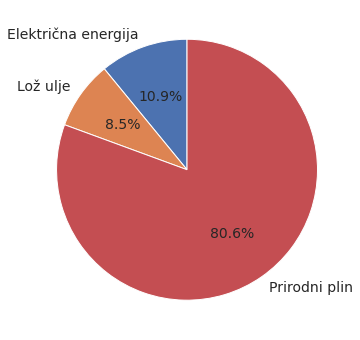

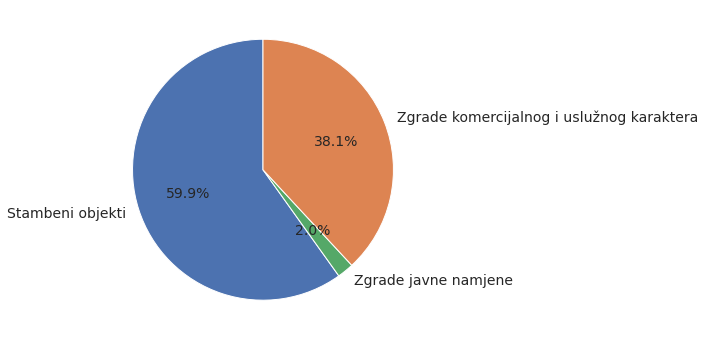

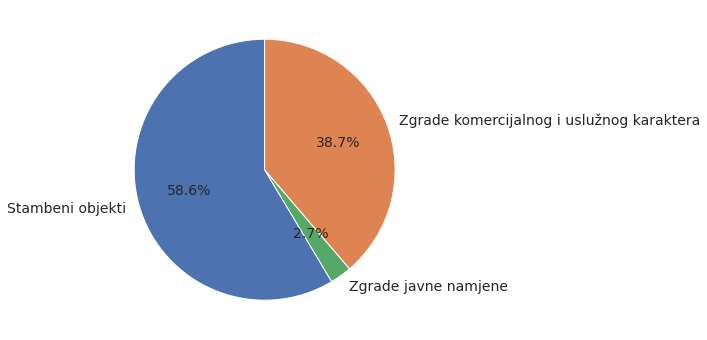

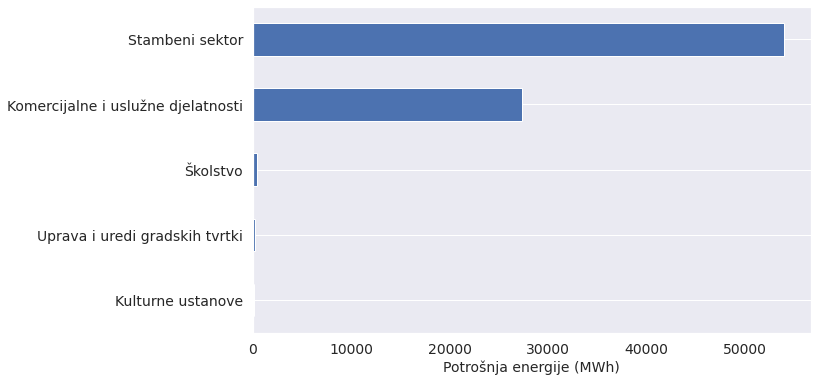

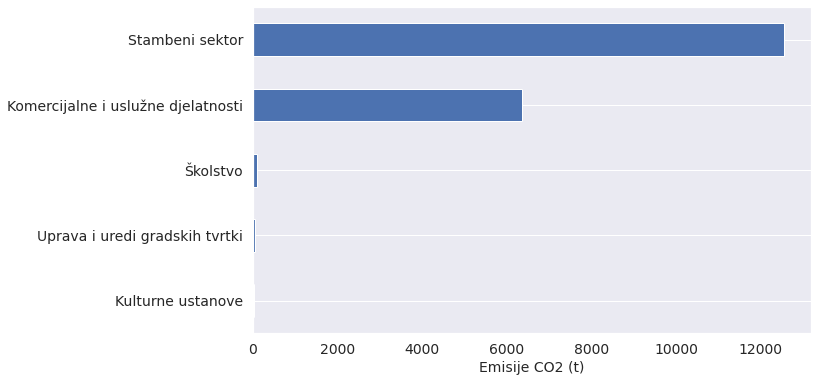

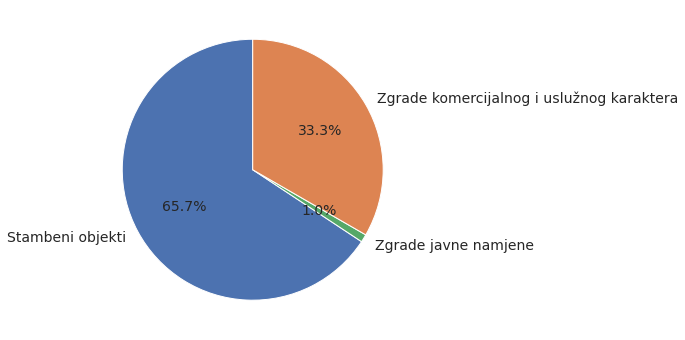

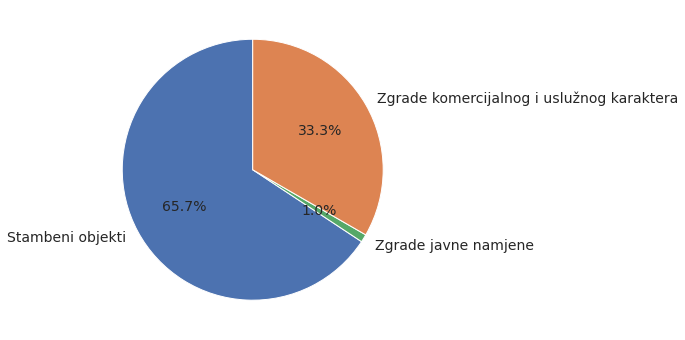

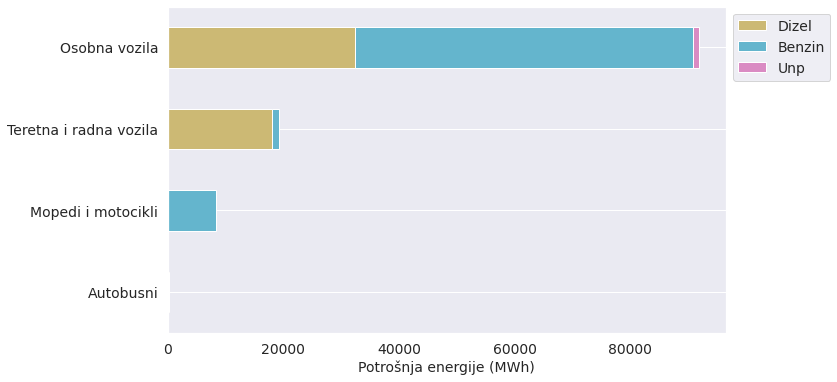

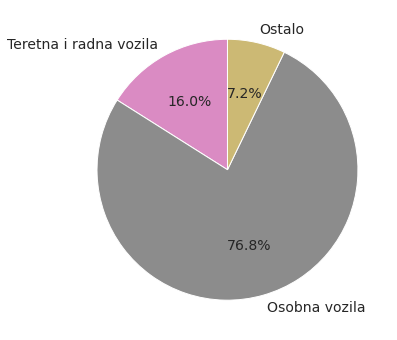

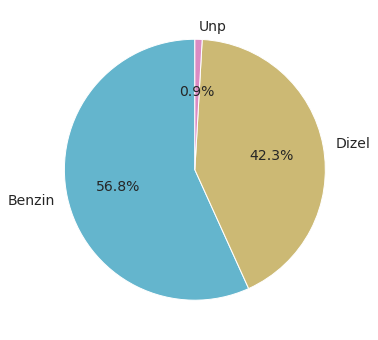

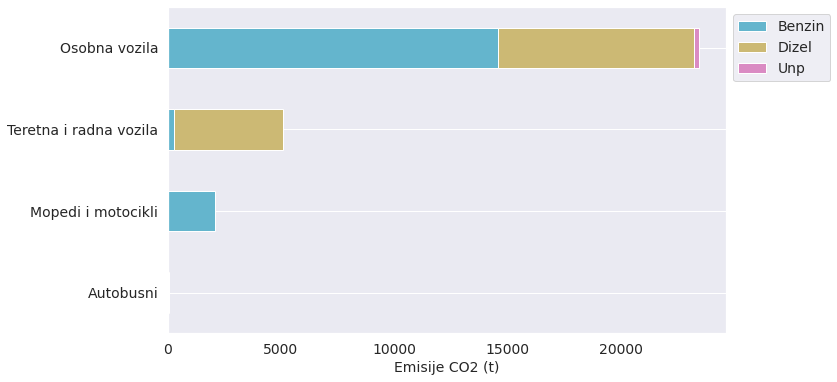

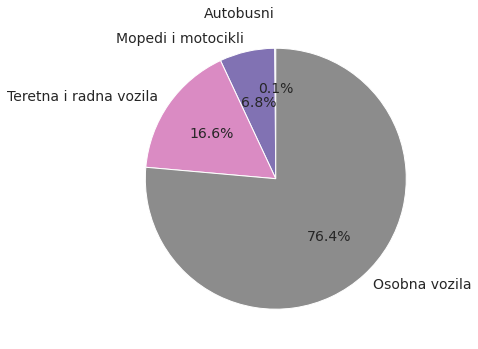

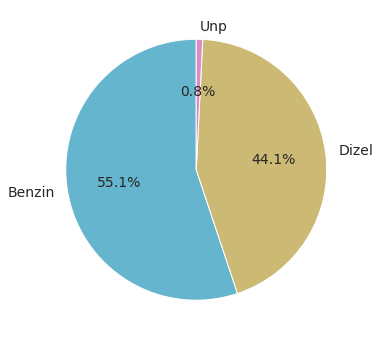

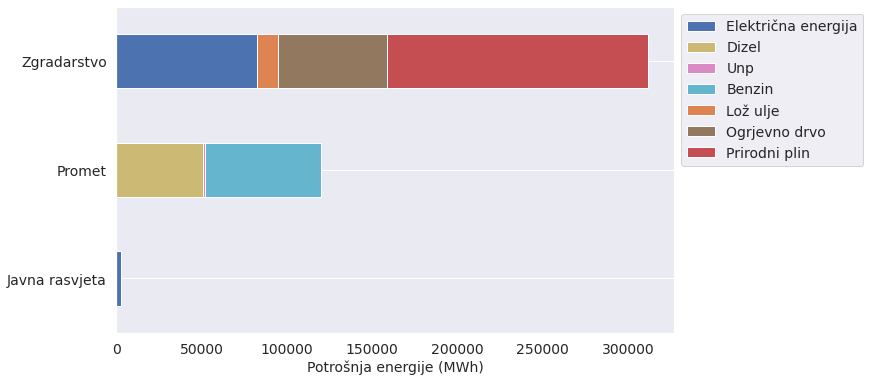

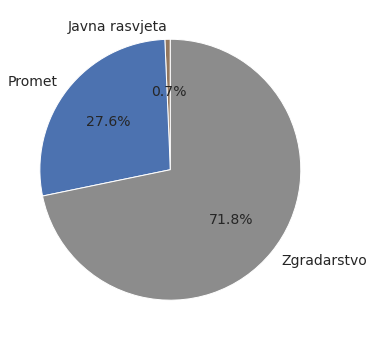

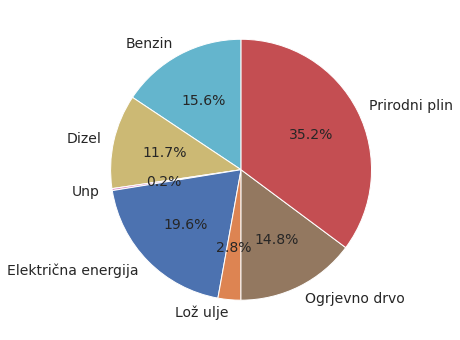

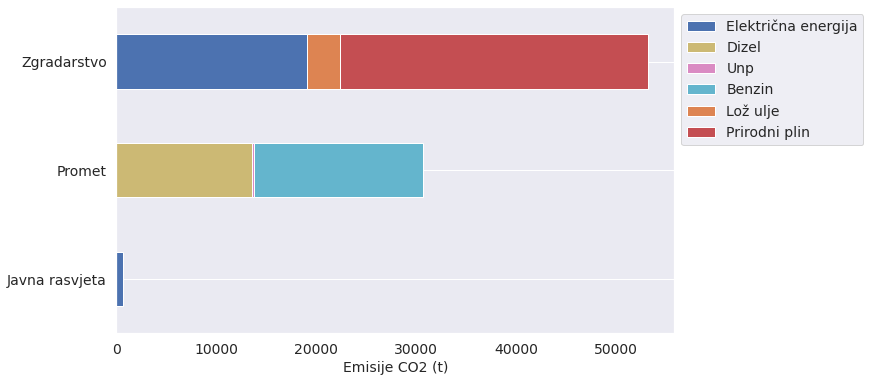

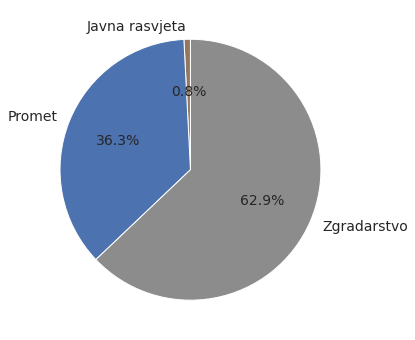

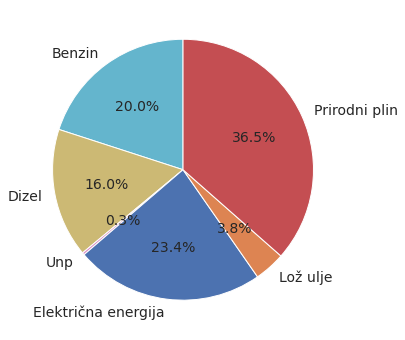

In [5]:
constants = Constants()
# 2011
output_dir = root_dir / 'output/2011/'
heat = pd.read_csv(root_dir / 'data/2011/vinkovci_grijanje_2011.csv')
ele = pd.read_csv(root_dir / 'data/2011/vinkovci_struja_2011.csv')
trans = pd.read_csv(root_dir / 'data/2011/privatna_vozila_2011.csv')
light = ['električna energija', 2922.5, 678.0, 'javna rasvjeta']

# group heat to fit 2019 format
heat['kategorija'] = heat['kategorija'].replace('objekti i uredi gradskih tvrtki', 'uprava i uredi gradskih tvrtki')
heat['kategorija'] = heat['kategorija'].replace('uprava', 'uprava i uredi gradskih tvrtki')
heat = heat.groupby(['nadkategorija', 'kategorija', 'energent'], as_index=False).sum()

# group electricity to fit 2019 format
ele['kategorija'] = ele['kategorija'].replace('objekti i uredi gradskih tvrtki', 'uprava i uredi gradskih tvrtki')
ele['kategorija'] = ele['kategorija'].replace('uprava', 'uprava i uredi gradskih tvrtki')
ele = ele.groupby(['nadkategorija', 'kategorija'], as_index=False).sum()


# fuel consumption is 2011 is too low, adjust to the same calculation as in 2019
km_per_vehicle = 12542 # same km per year per vehicle
factor = constants.specific_consumption_petrol_2000 / constants.specific_consumption_diesel_2000 # how much more petrol is spent
# adjust the fuel to get proportions
petrol_adj = trans.loc[trans['vrsta_prijevoza'] == 'osobna vozila'][
                 'procijenjena_potrošena_masa_benzina(t)'] / factor
lpg_adj = trans.loc[trans['vrsta_prijevoza'] == 'osobna vozila']['procijenjena_potrošena_masa_unp(t)'] / factor
diesel_adj = trans.loc[trans['vrsta_prijevoza'] == 'osobna vozila']['procijenjena_potrošena_masa_dizela(t)']
total = petrol_adj + lpg_adj + diesel_adj

prop_petrol = petrol_adj / total
prop_lpg = lpg_adj / total
prop_diesel = diesel_adj / total

# calculate tons of fuel
diesel_spent = prop_diesel * trans.loc[trans['vrsta_prijevoza'] == 'osobna vozila'][
    'broj'] * km_per_vehicle * constants.specific_consumption_diesel_2000 * constants.diesel_litre_to_ton
petrol_spent = prop_petrol * trans.loc[trans['vrsta_prijevoza'] == 'osobna vozila'][
    'broj'] * km_per_vehicle * constants.specific_consumption_petrol_2000 * constants.petrol_litre_to_ton
lpg_spent = prop_lpg * trans.loc[trans['vrsta_prijevoza'] == 'osobna vozila'][
    'broj'] * km_per_vehicle * constants.specific_consumption_petrol_2000 * constants.lpg_petrol_index * constants.lpg_litre_to_ton

# fix values for cars
trans.loc[trans['vrsta_prijevoza'] == 'osobna vozila', 'procijenjena_potrošena_masa_benzina(t)'] = petrol_spent
trans.loc[trans['vrsta_prijevoza'] == 'osobna vozila', 'procijenjena_potrošena_masa_dizela(t)'] = diesel_spent
trans.loc[trans['vrsta_prijevoza'] == 'osobna vozila', 'procijenjena_potrošena_masa_unp(t)'] = lpg_spent

# fix values for trucks
petrol_adj = trans.loc[trans['vrsta_prijevoza'] == 'teretna i radna vozila'][
                 'procijenjena_potrošena_masa_benzina(t)'] / factor
diesel_adj = trans.loc[trans['vrsta_prijevoza'] == 'teretna i radna vozila']['procijenjena_potrošena_masa_dizela(t)']
total = petrol_adj + diesel_adj

prop_petrol = petrol_adj / total
prop_diesel = diesel_adj / total

diesel_spent = prop_diesel * trans.loc[trans['vrsta_prijevoza'] == 'teretna i radna vozila'][
    'broj'] * km_per_vehicle * constants.specific_consumption_diesel_2000 * constants.diesel_litre_to_ton
petrol_spent = prop_petrol * trans.loc[trans['vrsta_prijevoza'] == 'teretna i radna vozila'][
    'broj'] * km_per_vehicle * constants.specific_consumption_petrol_2000 * constants.petrol_litre_to_ton

trans.loc[trans['vrsta_prijevoza'] == 'teretna i radna vozila', 'procijenjena_potrošena_masa_benzina(t)'] = petrol_spent
trans.loc[trans['vrsta_prijevoza'] == 'teretna i radna vozila', 'procijenjena_potrošena_masa_dizela(t)'] = diesel_spent

# fix values for bikes
petrol_spent = trans.loc[trans['vrsta_prijevoza'] == 'mopedi i motocikli'][
    'broj'] * km_per_vehicle * constants.specific_consumption_petrol_2000 * constants.petrol_litre_to_ton
trans.loc[
    trans['vrsta_prijevoza'] == 'mopedi i motocikli', 'procijenjena_potrošena_masa_benzina(t)'] = petrol_spent

base_inventory_2011 = Inventory(constants, 2011)
inventory_2011 = base_inventory_2011.base_inventory(output_dir, heat, ele, trans, light)

In [6]:
inventory_2011.keys()

dict_keys(['heat', 'heat_co2', 'electricity', 'electricity_co2', 'transport', 'transport_co2', 'total', 'total_co2'])

## Potrošnja topline u zgradarstvu

* Tablica 1 po energentu

In [7]:
inventory_2011['heat']

energent,prirodni plin,lož ulje,ogrjevno drvo,električna energija
kategorija,,,,
kulturne ustanove,657.7,63.3,0.0,0.0
uprava i uredi gradskih tvrtki,1066.9,0.0,0.0,37.8
školstvo,3219.4,15.3,0.0,0.0
komercijalne i uslužne djelatnosti,62307.6,6441.3,23188.6,2340.4
stambeni sektor,85563.1,5760.0,41250.8,15646.1


In [8]:
inventory_2011['heat'].sum()

energent
prirodni plin         152814.7
lož ulje               12279.8
ogrjevno drvo          64439.4
električna energija    18024.4
dtype: float64

In [9]:
inventory_2011['heat'].sum().sum()

247558.33119

* Tablica 1 po sektoru

In [10]:
inventory_2011['heat'].sum(axis=1)

kategorija
kulturne ustanove                       720.9
uprava i uredi gradskih tvrtki         1104.7
školstvo                               3234.7
komercijalne i uslužne djelatnosti    94277.9
stambeni sektor                      148220.0
dtype: float64

In [11]:
inventory_2011['heat'].sum(axis=1).sum()

247558.33119

## Emisije CO2 toplinske energije u sektoru zgradarstva

* Tablica 2 po energentu

In [12]:
inventory_2011['heat_co2']

energent,prirodni plin,lož ulje,ogrjevno drvo,električna energija
kategorija,,,,
kulturne ustanove,132.9,16.7,0.0,0.0
uprava i uredi gradskih tvrtki,215.5,0.0,0.0,8.8
školstvo,650.3,4.0,0.0,0.0
komercijalne i uslužne djelatnosti,12586.1,1700.5,0.0,543.7
stambeni sektor,17283.7,1520.6,0.0,3634.9


In [13]:
inventory_2011['heat_co2'].sum()

energent
prirodni plin         30868.6
lož ulje               3241.9
ogrjevno drvo             0.0
električna energija    4187.4
dtype: float64

* Tablica 2 po sektoru

In [14]:
inventory_2011['heat_co2'].sum(axis=1)

kategorija
kulturne ustanove                      149.6
uprava i uredi gradskih tvrtki         224.3
školstvo                               654.4
komercijalne i uslužne djelatnosti   14830.4
stambeni sektor                      22439.3
dtype: float64

In [15]:
inventory_2011['heat_co2'].sum(axis=1).sum()

38297.86441327803

## Potrošnja struje

In [16]:
inventory_2011['electricity']

kategorija
kulturne ustanove                      125.7
uprava i uredi gradskih tvrtki         220.3
školstvo                               455.9
komercijalne i uslužne djelatnosti   27390.0
stambeni sektor                      54014.0
Name: potrošnja_energije(MWh), dtype: float64

In [17]:
inventory_2011['electricity'].sum()

82205.917

## Emisije CO2 iz potrošnje struje

In [18]:
inventory_2011['electricity_co2']

kategorija
kulturne ustanove                       29.2
uprava i uredi gradskih tvrtki          51.2
školstvo                               105.9
komercijalne i uslužne djelatnosti    6363.2
stambeni sektor                      12548.5
Name: Emisije CO2 (t), dtype: float64

In [19]:
inventory_2011['electricity_co2'].sum()

19098.05893842394

## Potrošnja u prometu

In [20]:
trans

,vrsta_prijevoza,broj,procijenjena_potrošena_masa_benzina(t),procijenjena_potrošena_masa_dizela(t),procijenjena_potrošena_masa_unp(t)
0,autobusni,6,nan,13.9,nan
1,taxi,1,nan,1.6,nan
2,osobna vozila,10005,4753.5,2723.0,81.9
3,teretna i radna vozila,2102,88.0,1522.4,nan
4,mopedi i motocikli,910,683.9,nan,nan


In [21]:
trans.sum()

vrsta_prijevoza                           autobusnitaxiosobna vozilateretna i radna vozi...
broj                                                                                  13024
procijenjena_potrošena_masa_benzina(t)                                               5525.4
procijenjena_potrošena_masa_dizela(t)                                                4260.8
procijenjena_potrošena_masa_unp(t)                                                     81.9
dtype: object

* U MWh

In [22]:
inventory_2011['transport'].sum(axis=1)

vrsta_prijevoza
autobusni                  165.4
mopedi i motocikli        8411.5
teretna i radna vozila   19198.9
osobna vozila            91944.5
dtype: float64

In [23]:
inventory_2011['transport'].sum(axis=1).sum()

119720.28543597674

## Potrošnja CO2 u prometu

In [24]:
inventory_2011.keys()

dict_keys(['heat', 'heat_co2', 'electricity', 'electricity_co2', 'transport', 'transport_co2', 'total', 'total_co2'])

In [25]:
inventory_2011['transport_co2']

energent,Benzin,Dizel,UNP
vrsta_prijevoza,,,
autobusni,0.0,44.2,0.0
mopedi i motocikli,2094.5,0.0,0.0
teretna i radna vozila,269.6,4837.0,0.0
osobna vozila,14558.5,8651.6,243.7


In [26]:
inventory_2011['transport_co2'].sum()

energent
Benzin   16922.6
Dizel    13532.8
UNP        243.7
dtype: float64

In [27]:
inventory_2011['transport_co2'].sum(axis=1)

vrsta_prijevoza
autobusni                   44.2
mopedi i motocikli        2094.5
teretna i radna vozila    5106.6
osobna vozila            23453.8
dtype: float64

In [28]:
inventory_2011['transport_co2'].sum(axis=1).sum()

30699.062847537818

## Ukupna potrošnja

In [29]:
inventory_2011['total'].T

sektor,javna rasvjeta,promet,zgradarstvo
energent,,,
električna energija,2922.5,0.0,82205.9
Dizel,0.0,50684.8,0.0
UNP,0.0,1073.4,0.0
Benzin,0.0,67962.1,0.0
lož ulje,0.0,0.0,12279.8
ogrjevno drvo,0.0,0.0,64439.4
prirodni plin,0.0,0.0,152814.7


In [30]:
inventory_2011['total'].T.sum()

sektor
javna rasvjeta     2922.5
promet           119720.3
zgradarstvo      311739.9
dtype: float64

In [31]:
inventory_2011['total'].T.sum().sum()

434382.66562597675

In [32]:
inventory_2011['total'].sum()

energent
električna energija    85128.4
Dizel                  50684.8
UNP                     1073.4
Benzin                 67962.1
lož ulje               12279.8
ogrjevno drvo          64439.4
prirodni plin         152814.7
dtype: float64

## Ukupne emisije CO2

In [33]:
inventory_2011['total_co2'].T

sektor,javna rasvjeta,promet,zgradarstvo
energent,,,
električna energija,678.0,0.0,19098.1
Dizel,0.0,13532.8,0.0
UNP,0.0,243.7,0.0
Benzin,0.0,16922.6,0.0
lož ulje,0.0,0.0,3241.9
prirodni plin,0.0,0.0,30868.6


In [34]:
inventory_2011['total_co2'].T.sum()

sektor
javna rasvjeta     678.0
promet           30699.1
zgradarstvo      53208.5
dtype: float64

In [35]:
inventory_2011['total_co2'].T.sum().sum()

84585.56934466175

In [36]:
inventory_2011['total_co2'].sum()

energent
električna energija   19776.1
Dizel                 13532.8
UNP                     243.7
Benzin                16922.6
lož ulje               3241.9
prirodni plin         30868.6
dtype: float64

# 2019 inventar

In [ ]:
# 2019
output_dir = root_dir / 'output/2019/'
heat_2019 = pd.read_csv(root_dir / 'data/2019/vinkovci_grijanje_2019.csv')
ele_2019 = pd.read_csv(root_dir / 'data/2019/vinkovci_struja_2019.csv')
trans_2019 = pd.read_csv(root_dir / 'data/2019/privatna_vozila_2019.csv')
light_2019_mwh = 2008.656
light_2019_co2 = light_2019_mwh * constants.co2_electricity_mwh_ton_2019
light_2019 = ['električna energija', light_2019_mwh, light_2019_co2, 'javna rasvjeta']

base_inventory_2019 = Inventory(constants, 2019)
inventory_2019 = base_inventory_2019.base_inventory(output_dir, heat_2019, ele_2019, trans_2019, light_2019)

In [ ]:
inventory_2019.keys()

## Potrošnja energije

In [ ]:
inventory_2019['heat']

In [ ]:
inventory_2019['heat'].sum()

In [ ]:
inventory_2019['heat'].sum(axis=1)

In [ ]:
inventory_2019['heat'].sum().sum()

## Potrošnja CO2

In [ ]:
inventory_2019['heat_co2']

In [ ]:
inventory_2019['heat_co2'].sum()

In [ ]:
inventory_2019['heat_co2'].sum(axis=1)

In [ ]:
inventory_2019['heat_co2'].sum().sum()

## Struja

In [ ]:
inventory_2019['electricity']

In [ ]:
inventory_2019['electricity'].sum()

## Struja CO2

In [ ]:
inventory_2019['electricity_co2']

In [ ]:
inventory_2019['electricity_co2'].sum()

## Transport

In [ ]:
trans_2019

In [ ]:
trans_2019.sum()

In [ ]:
inventory_2019['transport'].sum(axis=1).sum()

## Transport CO2

In [ ]:
inventory_2019['transport_co2']

In [ ]:
inventory_2019['transport_co2'].sum()

In [ ]:
inventory_2019['transport_co2'].sum(axis=1)

In [ ]:
inventory_2019['transport_co2'].sum(axis=1).sum()

## UKupna potrošnja

In [ ]:
inventory_2019['total'].T

In [ ]:
inventory_2019['total'].T.sum(axis=1)

In [ ]:
inventory_2019['total'].T.sum()

In [ ]:
inventory_2019['total'].T.sum().sum()

## Ukupna potrošnja CO2

In [ ]:
inventory_2019['total_co2'].T

In [ ]:
inventory_2019['total_co2'].T.sum()

In [ ]:
inventory_2019['total_co2'].T.sum(axis=1)

In [ ]:
inventory_2019['total_co2'].T.sum().sum()

# Usporedba

In [ ]:
co2_keys = [key for key in inventory_2019.keys() if key.endswith('co2')]
mwh_keys = [key for key in inventory_2019.keys() if not key.endswith('co2')]

In [ ]:
output_dir = root_dir / 'output/2011v2019/'

for key in co2_keys:
    comparison_fig = base_inventory_2019.compare_stacked_bar(
        inventory_2011[key],
        inventory_2019[key],
        '2011',
        '2019',
        title='Emisije CO2 (t)',
    )
    comparison_fig.savefig(output_dir / '{}_comparison.png'.format(key), dpi=300, bbox_inches='tight')
    
for key in mwh_keys:
    comparison_fig = base_inventory_2019.compare_stacked_bar(
        inventory_2011[key],
        inventory_2019[key],
        '2011',
        '2019',
        title='Potrošnja energije (MWh)',
    )
    comparison_fig.savefig(output_dir / '{}_comparison.png'.format(key), dpi=300, bbox_inches='tight')